In [1]:
import sympy as sm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

sp.__version__

'1.10.1'

#### Алгоритмы планирования траекторий
##### Генерация $\mathcal{C}^0$ гладкой траектории через 10 точек. 

In [2]:
# Координаты точек:
x = [3, -2, 2,13,18, 7, 9,15,5,1]
y = [13,19,23,17,11,15, 8, 6,4,1]
coordinates = {'x':x, 'y':y}

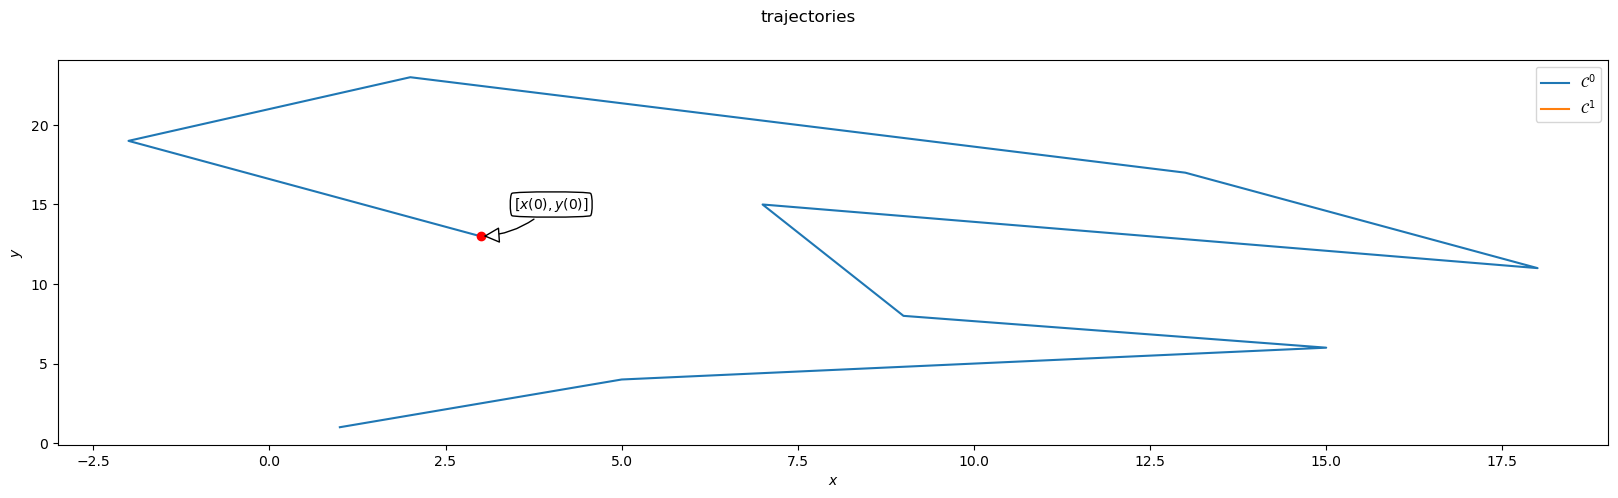

In [79]:
fig, ax = plt.subplots(1,1,figsize = (20,5))
ax = [ax, 1]
C0, = ax[0].plot(coordinates['x'],coordinates['y'])
# C1, = ax[0].plot(coordinates['y'],coordinates['x'])

ax[0].plot(coordinates['x'][0],coordinates['y'][0],'or')

ax[0].annotate(rf'$[x(0),y(0)]$',
                  xy=(coordinates['x'][0],coordinates['y'][0]),
                  xytext=(coordinates['x'][0]+1,coordinates['y'][0]+2),
                  size=10, va="center", ha="center",
                  bbox=dict(boxstyle="round4", fc="w"),
                  arrowprops=dict(arrowstyle="-|>",mutation_scale=25,
                                  connectionstyle="arc3,rad=-0.2", fc="w"))
fig.suptitle("trajectories")
ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$y$")
ax[0].legend([C0,C1], ['$\mathcal{C}^0$','$\mathcal{C}^1$'])